# Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit

Let's make sure that we are using numpy 1.26.4 for backwards compatibility (last version before 2.0, which doesn't yet have support from all packages):

In [2]:
np.version.version

'1.26.4'

# A simple LIF neuron

https://colab.research.google.com/github/johanjan/MOOC-HPFEM-source/blob/master/LIF_ei_balance_irregularity.ipynb#scrollTo=Hhk7e-QreVSh

In [3]:
class LIF_neuron:
    def __init__(self, params):
        # attach parameters to object
        self.V_th, self.V_reset = params['V_th'], params['V_reset']   
        self.tau_m, self.g_L = params['tau_m'], params['g_L']        
        self.V_init, self.V_L = params['V_init'], params['V_L']       
        self.dt = params['dt']
        self.tau_ref = params['tau_ref']

        # initialize voltage and current
        self.v = 0.0
        # time steps since last spike
        self.refractory_counter = 0
    
    def LIF_step(self, I):
        """
            Perform one step of the LIF dynamics
        """
        
        currently_spiking = False
        
        if self.refractory_counter > 0:
            # if the neuron is still refractory
            self.v = self.V_reset
            self.refractory_counter = self.refractory_counter - 1
        elif self.v >= self.V_th:
            # if v is above threshold,
            # reset voltage and record spike event
            currently_spiking = True
            self.v = self.V_reset
            self.refractory_counter = self.tau_ref/self.dt
        else:
            # else, integrate the current:
            # calculate the increment of the membrane potential
            dv = self.voltage_dynamics(I)
            # update the membrane potential
            self.v = self.v + dv

        return self.v, currently_spiking
    
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the LI dynamics
        """
        dv = (-(self.v-self.V_L) + I/self.g_L) * (self.dt/self.tau_m)
        return dv
        

In [4]:
params = {}
### typical neuron parameters###
params['V_th']    = -55. # spike threshold [mV]
params['V_reset'] = -75. #reset potential [mV]
params['tau_m']   = 10. # membrane time constant [ms]
params['g_L']     = 10. #leak conductance [nS]
params['V_init']  = -65. # initial potential [mV]
params['V_L']     = -75. #leak reversal potential [mV]
params['tau_ref']    = 2. # refractory time (ms)
params['dt'] = .1  # Simulation time step [ms]

In [5]:
# initialize one neuron, i.e. an instance of the class
neuron1 = LIF_neuron(params)

In [6]:
# let's check if everything works by performing one step:
neuron1.LIF_step(I=300.0)

(-75.0, True)

In [7]:
# simulate 500 time steps
voltages = []
spikes = []
for _ in range(500):
    v, s = neuron1.LIF_step(I=300.0)
    voltages.append(v)
    spikes.append(s)

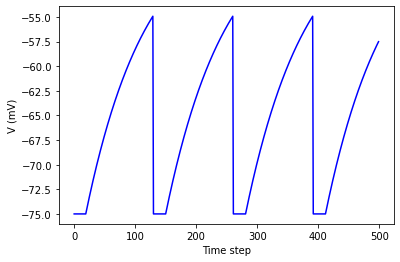

In [8]:
plt.figure()
plt.plot(voltages, c='blue')
# for s in np.where(spikes)[0]:
#     plt.axvline(s, c='red')
plt.xlabel('Time step')
plt.ylabel('V (mV)');
plt.show()

# Overriding classes with __super__

In [9]:
class ExpLIF_neuron(LIF_neuron):
    def __init__(self, params):
        # build on LIF neuron with same settings
        super().__init__(params)
        
        # we only need to attach additional variables:
        self.DeltaT = params['DeltaT']
        self.V_exp_trigger = params['V_exp_trigger']
        
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the exp-LI dynamics
        """
        dv = (-(self.v-self.V_L) + I/self.g_L + self.DeltaT * np.exp((self.v-self.V_exp_trigger)/self.DeltaT)) * (self.dt/self.tau_m)
        return dv
        

In [10]:
# additional parameters for ExpLIF neurons
params['DeltaT'] = 10.0  # sharpness of exponential peak
params['V_exp_trigger'] = -55. # threshold for exponential depolarization [mV]
params['V_th'] = 0 # new spike threshold [mV]

In [11]:
# initialize one neuron
neuron2 = ExpLIF_neuron(params)

In [12]:
# simulate 500 time steps
voltages = []
spikes = []
for _ in range(500):
    v, s = neuron2.LIF_step(I=300.0)
    voltages.append(v)
    spikes.append(s)

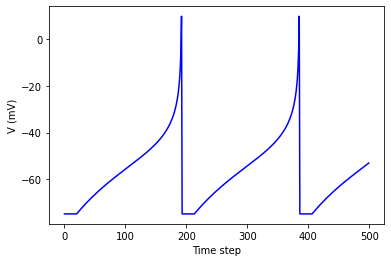

In [13]:
plt.figure()
plt.plot(voltages, c='blue')
# for s in np.where(spikes)[0]:
#     plt.axvline(s, c='red')
# plt.xlim(0, 100)
plt.xlabel('Time step')
plt.ylabel('V (mV)');
plt.show()

# Mutability

# Extending to populations, or: resisting the urge to hack it

Let's say we want to simulate a population of 100 neurons. We could use the classes above:

In [14]:
# population parameters
n_neurons = 100

population1 = [ExpLIF_neuron(params) for _ in range(n_neurons)]

In [15]:
# # we now have a list of 100 neuron objects:
# population1

Let's give them all noisy currents:

In [16]:
mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for i, neuron in enumerate(population1):
    voltages = []
    spikes = []
    if i % 10 == 0:
        print(f"Working on neuron {i}")
    for _ in range(n_steps):
        I = np.random.normal(mean_I, std_I)
        v, s = neuron.LIF_step(I=I)
        voltages.append(v)
        spikes.append(s)
    voltages_arr.append(voltages.copy())
    spikes_arr.append(spikes.copy())

Working on neuron 0
Working on neuron 10
Working on neuron 20
Working on neuron 30
Working on neuron 40
Working on neuron 50
Working on neuron 60
Working on neuron 70
Working on neuron 80
Working on neuron 90


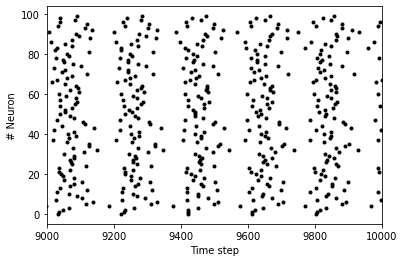

In [17]:
# convert to numpy array
voltages_arr = np.array(voltages_arr)
spikes_arr = np.array(spikes_arr)

# convert spikes to spike_timings
spike_timings = [arr.nonzero()[0] for arr in spikes_arr]

for i in range(n_neurons):
    x = spike_timings[i]
    y = [i for _ in spike_timings[i]]
    plt.scatter(x, y, marker='.', c='black')
plt.xlim(9000,10000)
plt.xlabel('Time step')
plt.ylabel('# Neuron')
plt.show()

But that of course scales terribly, because every neuron is simulated sequentially.

In [18]:
class ExpLIF_population:
    def __init__(self, params):
        # attach parameters to object
        self.V_th, self.V_reset = params['V_th'], params['V_reset']   
        self.tau_m, self.g_L = params['tau_m'], params['g_L']        
        self.V_init, self.V_L = params['V_init'], params['V_L']       
        self.dt = params['dt']
        self.tau_ref = params['tau_ref']
        self.DeltaT = params['DeltaT']
        self.V_exp_trigger = params['V_exp_trigger']
        
        # number of neurons
        self.n_neurons = params["n_neurons"]

        # initialize voltage and current
        self.v = np.zeros(self.n_neurons)
        # time steps since last spike
        self.refractory_counter = np.zeros(self.n_neurons)
            
    def LIF_step(self, I):
        """
            Perform one step of the LIF dynamics
        """
        
        currently_spiking = np.array([False for _ in range(self.n_neurons)])
        
        # first, we need to get indices of neurons which
        # are refractory, above threshold or neither:
        idx_ref = np.where(self.refractory_counter > 0)[0]
        idx_spk = np.where(self.v > self.V_th)[0]
        
        # exclude the other two cases
        idx_else = np.where((self.refractory_counter <= 0) & (self.v <= self.V_th))[0]
        
        # if the neuron is still refractory
        self.v[idx_ref] = self.V_reset
        self.refractory_counter[idx_ref] -= 1
        
        # if v is above threshold,
        # reset voltage and record spike event
        currently_spiking[idx_spk] = True
        self.v[idx_spk] = self.V_reset
        self.refractory_counter[idx_spk] = self.tau_ref/self.dt
        
        # calculate the increment of the membrane potential
        dv = self.voltage_dynamics(I)
        # update the membrane potential only for non-spiking neurons
        self.v[idx_else] += dv[idx_else]

        return self.v, currently_spiking
        
    def voltage_dynamics(self, I):
        """
            Calulcates one step of the exp-LI dynamics
        """
        dv = (-(self.v-self.V_L) + I/self.g_L + self.DeltaT * np.exp((self.v-self.V_exp_trigger)/self.DeltaT)) * (self.dt/self.tau_m)
        return dv
        

In [19]:
# population parameters
n_neurons = 100
params["n_neurons"] = n_neurons

population2 = ExpLIF_population(params)

In [20]:
mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for _ in range(n_steps):
    I = np.random.normal(mean_I, std_I, size=n_neurons)
    v, s = population2.LIF_step(I=I)
    voltages_arr.append(v.copy())
    spikes_arr.append(s.copy())

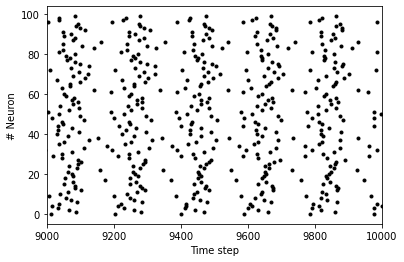

In [21]:
# convert to numpy array
voltages_arr = np.array(voltages_arr)
spikes_arr = np.array(spikes_arr)

# convert spikes to spike_timings
# spike_timings = spikes_arr.T.nonzero()[0]

for i in range(n_neurons):
    x = spikes_arr[:,i].nonzero()[0]
    y = [i for _ in range(len(x))]
    plt.scatter(x, y, marker='.', c='black')
plt.xlim(9000,10000)
plt.xlabel('Time step')
plt.ylabel('# Neuron')
plt.show()

# Timeit and memory allocation

The code we wrote works, but there several things that we can do to make it run faster.

In [38]:
params["n_neurons"] = 10_000
params["n_steps"] = 10_000
n_neurons = params["n_neurons"]
n_steps = params["n_steps"]

mean_I, std_I = 300, 100

In [32]:
# %%timeit -n 1 -r 3

# population1 = [ExpLIF_neuron(params) for _ in range(n_neurons)]

# # these will now become lists of lists (neurons, time steps)
# voltages_arr = []
# spikes_arr = []

# for i, neuron in enumerate(population1):
#     voltages = []
#     spikes = []
# #     if i % 10 == 0:
# #         print(f"Working on neuron {i}")
#     for _ in range(n_steps):
#         I = np.random.normal(mean_I, std_I)
#         v, s = neuron.LIF_step(I=I)
#         voltages.append(v)
#         spikes.append(s)
#     voltages_arr.append(voltages.copy())
#     spikes_arr.append(spikes.copy())

13.7 s ± 20.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [39]:
%%timeit -n 1 -r 3

population2 = ExpLIF_population(params)

mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = []
spikes_arr = []

for _ in range(n_steps):
    I = np.random.normal(mean_I, std_I, size=n_neurons)
    v, s = population2.LIF_step(I=I)
    voltages_arr.append(v.copy())
    spikes_arr.append(s.copy())

12.2 s ± 196 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [40]:
%%timeit -n 1 -r 3

population3 = ExpLIF_population(params)

mean_I, std_I = 300, 100
n_steps = 10_000

# these will now become lists of lists (neurons, time steps)
voltages_arr = np.zeros((n_steps, n_neurons))
spikes_arr = np.zeros((n_steps, n_neurons))

for i in range(n_steps):
    I = np.random.normal(mean_I, std_I, size=n_neurons)
    voltages_arr[i], spikes[i] = population3.LIF_step(I=I)

11.9 s ± 423 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


# Broadcasting